## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [28]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os
import shutil
import json
import random

from google.cloud.storage import Client

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

### Get data from GCS

In [3]:
client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="preisler-rectangular")
    if f.name.endswith("csv")
]

random.shuffle(records)

print("\n".join(records))

gs://preisler_tfdata/preisler-rectangular/yr2004.csv
gs://preisler_tfdata/preisler-rectangular/yr2021.csv
gs://preisler_tfdata/preisler-rectangular/yr2015.csv
gs://preisler_tfdata/preisler-rectangular/yr2012.csv
gs://preisler_tfdata/preisler-rectangular/yr2001.csv
gs://preisler_tfdata/preisler-rectangular/yr2017.csv
gs://preisler_tfdata/preisler-rectangular/yr2011.csv
gs://preisler_tfdata/preisler-rectangular/yr2019.csv
gs://preisler_tfdata/preisler-rectangular/yr2014.csv
gs://preisler_tfdata/preisler-rectangular/yr2008.csv
gs://preisler_tfdata/preisler-rectangular/yr2010.csv
gs://preisler_tfdata/preisler-rectangular/yr2002.csv
gs://preisler_tfdata/preisler-rectangular/yr2016.csv
gs://preisler_tfdata/preisler-rectangular/yr2003.csv
gs://preisler_tfdata/preisler-rectangular/yr2018.csv
gs://preisler_tfdata/preisler-rectangular/yr2020.csv
gs://preisler_tfdata/preisler-rectangular/yr2009.csv
gs://preisler_tfdata/preisler-rectangular/yr2000.csv
gs://preisler_tfdata/preisler-rectangular/yr20

In [4]:
ds = pd.concat((pd.read_csv(f).drop(["system:index", ".geo"], axis=1) for f in records), ignore_index=True)
ds.head()

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
0,0.00000,32.658025,-116.691155,0.000,0.0,375.181269,125.296807,355.344713,207.253639,0.0,-0.705917,2004
1,0.07375,32.658025,-116.655223,0.000,0.0,392.055676,131.980709,365.660167,214.474182,0.0,-1.145026,2004
2,0.00000,32.658025,-116.619290,0.000,0.0,424.923141,145.806077,376.597119,231.824489,0.0,-1.761723,2004
3,0.00000,32.658025,-116.583358,0.092,0.0,436.907098,145.179641,348.928246,228.756836,0.0,-2.335552,2004
4,0.00000,32.658025,-116.547425,0.092,0.0,473.272824,165.889346,367.590098,241.666355,0.0,-2.939018,2004


### Preprocessing

To match the paper, we have to convert `pct_mortality` to a binary variable. Technically there's another model on top of this one that predicts area affected by mortality given that some mortality is predicted. Also, to ensure that each batch learns from a variety of years and geographies, shuffle the data.

In [12]:
ds["mortality"] = ds["pct_mortality"] > 0
ds = ds.sample(frac=1).reset_index(drop=True)

In [19]:
ds

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year,mortality
0,0.0,34.217170,-116.727088,0.0048,0.0000,591.006162,268.731178,596.465212,83.265877,0.999481,-16.079512,2011,False
1,0.0,34.276575,-117.553538,0.0000,0.0000,421.855102,512.799522,82.056543,576.373747,0.152251,-7.985745,2010,False
2,0.0,41.497486,-120.823406,0.0000,0.0000,464.417491,444.641412,355.454210,241.729320,0.155606,-17.448292,2005,False
3,0.0,40.657817,-123.123093,0.0000,0.0008,1097.683250,789.033866,899.142699,726.748880,0.999200,-9.971143,2011,True
4,0.0,38.918471,-120.392214,0.4348,0.3148,1270.341609,2795.273110,1527.030037,895.267233,0.683078,-10.696132,2019,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346189,0.0,40.439389,-121.685788,0.0588,0.0336,1072.015881,1269.610732,1016.752459,1708.148673,0.966400,-6.920505,2015,True
346190,0.0,39.058119,-123.302756,0.0016,0.0000,1392.087442,1426.450536,838.507538,1214.500284,0.924773,-3.355072,2012,False
346191,0.0,39.030211,-120.859338,0.2080,0.0004,1103.067088,609.125038,886.279064,1670.989935,0.996427,-5.065059,2023,True
346192,0.0,35.660451,-118.056595,0.0108,0.0000,522.732284,159.648496,361.429172,66.407022,0.888786,-7.677223,2006,False


### Train-validate-test split

In [42]:
ds_train, ds_valid_test = train_test_split(ds, test_size=0.3, stratify=ds.year)
ds_valid, ds_test       = train_test_split(ds_valid_test, test_size=0.33, stratify=ds_valid_test.year)

print("Number of rows in")
print("Training:", ds_train.shape[0])
print("Validation:", ds_valid.shape[0])
print("Testing:", ds_test.shape[0])

Number of rows in
Training: 242335
Validation: 69585
Testing: 34274


In [56]:
# Convert to tfdatasets
targets = ["pct_mortality", "mortality"]

def df_to_tfdataset(df):
    inputs = dict(df.drop(targets, axis=1))
    outputs = dict(df[targets])
    return tf.data.Dataset.from_tensor_slices((inputs, outputs))

tf_train = df_to_tfdataset(ds_train)
tf_valid = df_to_tfdataset(ds_valid)
tf_test  = df_to_tfdataset(ds_test)

### Model building

In [57]:
import tensorflow.keras as keras

REG  = keras.regularizers.L1(0.001)
DROP = 0.2
ACT  = "tanh"

# print(sorted(list(spec.keys())))

def build_preisler_model(init_bias=None):
    # Inputs
    inputs =  [
        keras.layers.Input(shape=(1,), name=key)
        for key in ds.columns
        if key not in targets
    ]

    # Concatenate all the inputs together
    concat = keras.layers.Concatenate(axis=1)(inputs)

    # Normalize each parameter independently
    norm = keras.layers.BatchNormalization(axis=1)(concat)

    # Feed normalized data to a few dense layers with dropout
    d1 = keras.layers.Dense(128, activation=ACT)(norm)
    drop1 = keras.layers.Dropout(DROP)(d1)
    d2 = keras.layers.Dense(16, activation=ACT)(drop1)
    drop2 = keras.layers.Dropout(DROP)(d2)
    d3 = keras.layers.Dense(8, activation=ACT)(drop2)

    # Connect to output.
    if init_bias is not None:
        init_bias = tf.keras.initializers.Constant(init_bias)
        
    out_regr = keras.layers.Dense(
        1, activation="sigmoid", 
        name="pct_mortality",
        bias_initializer=init_bias
    )(d3)

    out_classif = keras.layers.Dense(
        1, activation="sigmoid", 
        name="mortality",
        bias_initializer=init_bias
    )(d3)

    return keras.models.Model(inputs=inputs, outputs=[out_regr, out_classif])

# Calculate initial bias
init_bias = np.log(np.sum(ds_train.mortality) / np.sum(~ds_train.mortality))
model = build_preisler_model(init_bias=init_bias)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fire (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 latitude (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 longitude (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 near (InputLayer)              [(None, 1)]          0           []                               
                                                                                            

### Model training

In [58]:
# Reset weights
model = build_preisler_model(init_bias=init_bias)

# Metric to monitor class imbalance
def pct_positive_cases(y_true, y_pred):
    return tf.math.reduce_mean(y_true)

classif_metrics = [
    keras.metrics.Precision(),
    keras.metrics.Recall(),
    keras.metrics.AUC(),
    pct_positive_cases
]

regr_metrics = [
    keras.metrics.RootMeanSquaredError(),
]

model.compile(
    loss={
        "pct_mortality": "mean_squared_error",
        "mortality": "binary_crossentropy"    
    },
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    metrics={
        "pct_mortality": regr_metrics,
        "mortality": classif_metrics
    }
)

In [59]:
# Callbacks
model_name = "preisler_dense_dual.keras"
earlystop = keras.callbacks.EarlyStopping(monitor="loss", patience=5)
checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("data_working", "models", model_name))
logdir = os.path.join("logs", model_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Delete any existing logs
for fname in os.listdir(logdir):
    file_path = os.path.join(logdir, fname)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except OSError as e:
        print("Failed to delete", file_path)

In [60]:
batch_size = 512

history = model.fit(
    x=tf_train.batch(batch_size),
    validation_data=tf_valid.batch(batch_size),
    epochs=30,
    verbose=1,
    callbacks=[checkpoint, tensorboard_callback]
)

Epoch 1/30
474/474 [==============================] - 7s 11ms/step - loss: 0.5076 - pct_mortality_loss: 0.0118 - mortality_loss: 0.4958 - pct_mortality_root_mean_squared_error: 0.1086 - mortality_precision_2: 0.6597 - mortality_recall_2: 0.5849 - mortality_auc_2: 0.8089 - mortality_pct_positive_cases: 0.3372 - val_loss: 0.6894 - val_pct_mortality_loss: 0.0085 - val_mortality_loss: 0.6808 - val_pct_mortality_root_mean_squared_error: 0.0923 - val_mortality_precision_2: 0.5707 - val_mortality_recall_2: 0.2377 - val_mortality_auc_2: 0.7210 - val_mortality_pct_positive_cases: 0.3375
Epoch 2/30
474/474 [==============================] - 5s 10ms/step - loss: 0.4841 - pct_mortality_loss: 0.0084 - mortality_loss: 0.4757 - pct_mortality_root_mean_squared_error: 0.0915 - mortality_precision_2: 0.6743 - mortality_recall_2: 0.6196 - mortality_auc_2: 0.8270 - mortality_pct_positive_cases: 0.3372 - val_loss: 0.4605 - val_pct_mortality_loss: 0.0068 - val_mortality_loss: 0.4538 - val_pct_mortality_root

### Show fit on training data

474/474 [==============================] - 3s 6ms/step


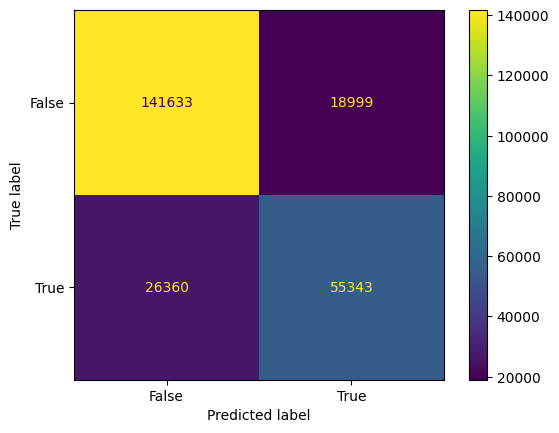

In [66]:
y_train = ds_train.mortality
y_train_hat = model.predict(tf_train.batch(512))[1]
y_train_hat_classif = y_train_hat > 0.5

ConfusionMatrixDisplay.from_predictions(y_train, y_train_hat_classif)
plt.show()

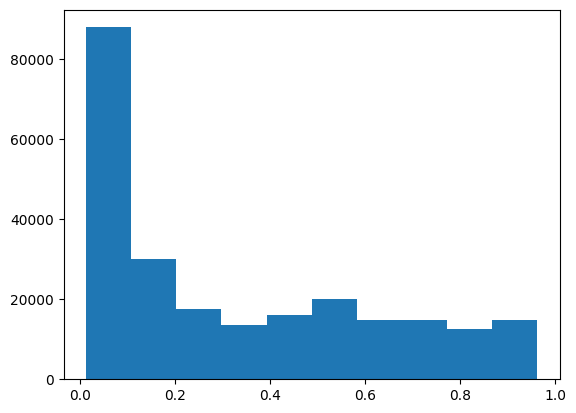

In [67]:
plt.hist(y_train_hat)
plt.show()

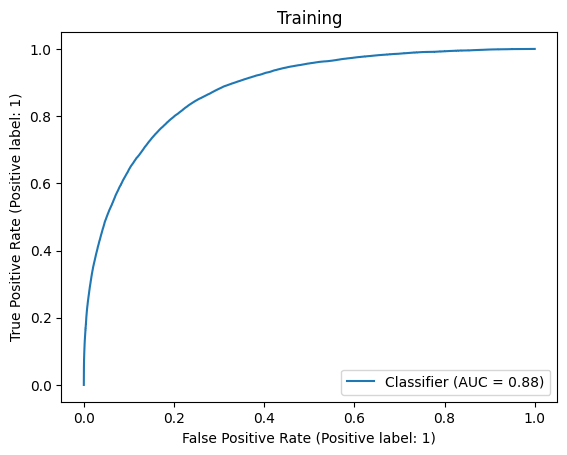

In [70]:
RocCurveDisplay.from_predictions(y_train, y_train_hat)
plt.title("Training")
plt.show()

### Evaluate on test data

67/67 [==============================] - 0s 6ms/step


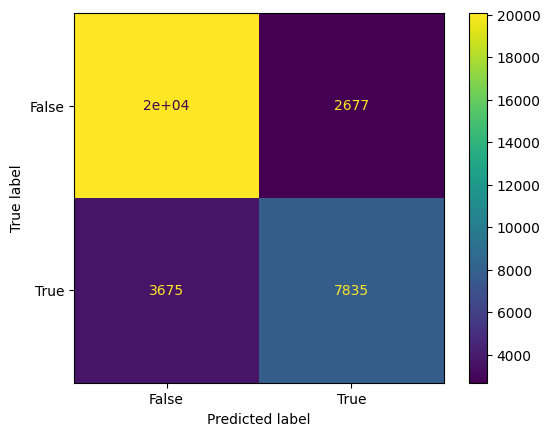

In [69]:
y_test = ds_test.mortality
y_test_hat = model.predict(tf_test.batch(512))[1]
y_test_hat_classif = y_test_hat > 0.5

ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat_classif)
plt.show()

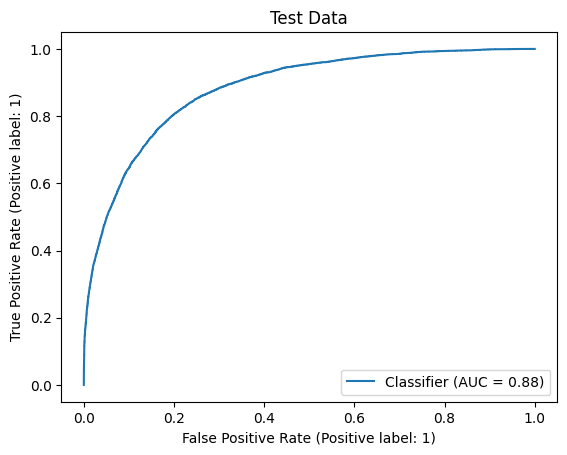

In [72]:
RocCurveDisplay.from_predictions(y_test, y_test_hat)
plt.title("Test Data")
plt.show()